In [1]:
#|echo: false

##---- Load all necessary libraries ----##

# math, df, os, misc.
import numpy as np
import pandas as pd
from pandas import read_csv
import scipy.io
import os
from tqdm import tqdm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# algorithms
from scipy.stats import multivariate_normal as mvn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

# 1 - Implementing EM for MNIST dataset

I will implement the EM algorithm for fitting a Gaussian mixture model for the MNIST handwritten digits dataset. For this question, we will reduce the dataset to be only two cases, of digits "2" and "6" only. Thus, I will fit GMM with $C = 2$ using the data file `data.mat` or `data.dat`. True label of the data are also provided in `label.mat` and `label.dat`.

The matrix `images` is of size 784-by-1990, i.e., there are 1990 images in total, and each column of the matrix corresponds to one image of size 28-by-28 pixels (the image is vectorized; the original image can be recovered by mapping the vector into a matrix).

First, I will use PCA to reduce the dimensionality of the data before applying to EM. I will put all "2" and "6" digits together, to project the original data into 4-dimensional vectors.

Next, I will implement the EM algorithm for the projected data with 4-dimensions. In this question, I use the same set of data from the provided data files for training and testing.

## 1.1 

Here, I will implement EM algorithm by myself using the following initialization:

- initialization for mean: random Gaussian vector with zero mean
- initialization for covariance: generate two Gaussian random matrix of size $n$-by-$n$: $S_1$ and $S_2$, and initialize the covariance matrix for the two components are $\Sigma_1 = S_1 S_1^T + I_n$, and  $\Sigma_2 = S_2 S_2^T + I_n$, where $I_n$ is an identity matrix of size $n$-by-$n$. 

I will also plot the log-likelihood function versus the number of iterations to show that the algorithm is converging.

In [2]:
#|echo: false

# load in data

data = scipy.io.loadmat('data/data.mat')['data'].T

true_labels = scipy.io.loadmat('data/label.mat')
true_labels = list(true_labels["trueLabel"][0])

In [3]:
#|echo: false

## From demo code module 7

def run_EM(data, seed = None):

    # ndata = preprocessing.scale(data)
    ndata = data
    m, n = ndata.shape
    C = np.matmul(ndata.T, ndata)/m

    # pca the data
    d = 4  # reduced dimension
    # values, V = np.linalg.eig(C)
    # ind = np.argsort(values)[::-1][:d]
    # V = V[:, ind]
    V,Sig,_ = np.linalg.svd(C)
    V = V[:, :d]

    # project the data to the top 4 principal directions
    pdata = np.dot(ndata,V)

    # EM-GMM for MNIST data
    # number of mixtures
    K = 2

    # random seed
    # seed = 123456
    if seed is None:
        seed = np.random.randint(0, 42949295)
        print(f'Running EM algorithm with random seed = {seed}')
    else:
        print(f'Running EM algorithm with set seed = {seed}')  
    np.random.seed(seed)
     
    # initialize prior
    pi = np.random.random(K)
    pi = pi/np.sum(pi)

    # initial mean and covariance
    ## -- Initialization for mean (random Gaussian vector with zero mean) --
    mu = np.random.randn(K, d)
    mu_old = mu.copy()

    sigma = []
    for ii in range(K):
        # to ensure the covariance psd
        # np.random.seed(seed)

        ## -- Initialization for covariance (two Gaussian random matrix of nxn + Identity matrix of nxn) --
        dummy = np.random.randn(d, d)
        sigma.append(dummy@dummy.T + np.identity(d))
        # print(dummy)
        
    # initialize the posterior
    tau = np.full((m, K), fill_value=0.)

    # ####
    maxIter= 100
    tol = 1e-3
    # plt.ion()

    log_likelihood = []
    iterations_count = []

    pbar = tqdm(desc='Progress', total = maxIter)

    for ii in range(maxIter):

        # E-step    
        for kk in range(K):
            tau[:, kk] = pi[kk] * mvn.pdf(pdata, mu[kk], sigma[kk])

        # normalize tau
        sum_tau = np.sum(tau, axis=1)
        sum_tau.shape = (m,1)    
        tau = np.divide(tau, np.tile(sum_tau, (1, K)))
        
        # M-step
        for kk in range(K):
            # update prior
            pi[kk] = np.sum(tau[:, kk])/m
            
            # update component mean
            mu[kk] = pdata.T @ tau[:,kk] / np.sum(tau[:,kk], axis = 0)
            
            # update cov matrix
            dummy = pdata - np.tile(mu[kk], (m,1)) # X-mu
            sigma[kk] = dummy.T @ np.diag(tau[:,kk]) @ dummy / np.sum(tau[:,kk], axis = 0)
            
        log_likelihood.append(np.sum(np.log(sum_tau)))
        iterations_count.append(ii)
        
        # print('-----iteration-----',ii)    
        fig = plt.figure(figsize=(6,8))
        plt.scatter(pdata[:,0], pdata[:,1], c = tau[:,0])
        plt.axis('scaled')
        plt.title(f'EM Convergence Plot - Iteration {ii}')
        # plt.draw()
        plt.tight_layout()
        plt.savefig(os.path.join("outputs", f'EM_scatter_iter_{ii}.jpg'))
        plt.close(fig)

        pbar.update(1)

        if np.linalg.norm(mu-mu_old) < tol:
            pbar.update(maxIter - pbar.n)
            pbar.close()
            print(f'\nTraining converged in {ii} iterations.')
            break

        mu_old = mu.copy()
        if ii== maxIter-1:
            print(f'\nMax iterations reached')
            break
            
    # part 1.a
    # Plot of log-likelihood vs iterations

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    # all log-likelihood values
    ax1.plot(iterations_count, log_likelihood, marker = 'o')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Log-likelihood value')
    ax1.set_title('GMM Model - Log-likelihood vs Number of Iterations')
    ax1.grid(True)
    # Log-likelihood values skipping the first one
    ax2.plot(iterations_count[1:], log_likelihood[1:], marker='o')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Log-likelihood value')
    ax2.set_title('GMM Model - Log-likelihood vs Number of Iterations (skipping first value)')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()
    
    return pi, mu, V, sigma, tau, pdata

Running EM algorithm with set seed = 123456


Progress: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]



Training converged in 21 iterations.


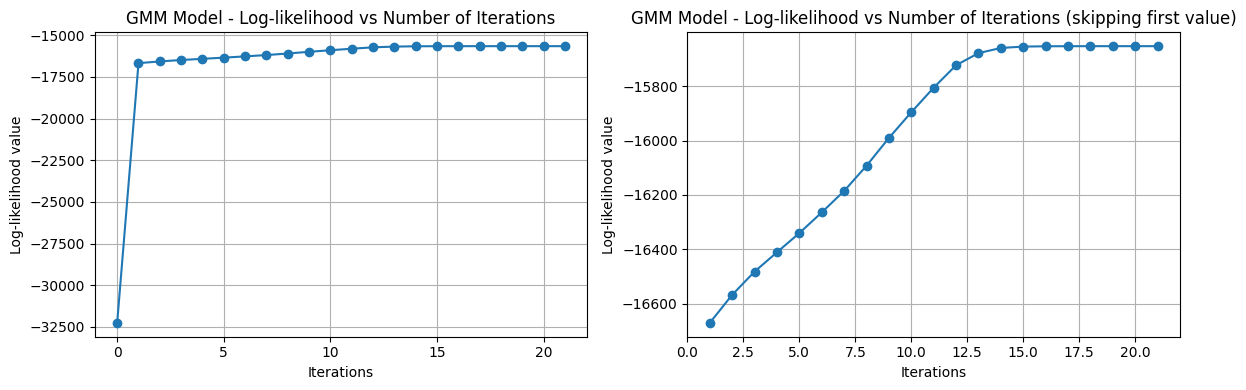

In [4]:
#|echo: false

weights, mean, V, sigma, tau, pca_data = run_EM(data, seed = 123456)

As seen from the plots above, the EM algorithm that I implemented from scratch using the demo code provided from the lectures converges after 21 iterations for this particular seed. I created two plots, one with all the values and another with the first value removed to better visualize the gradual converging of the algorithm. The performance of the EM algorithm can be seen in the following two animations:

- [EM Algorithm - 21 Iterations](outputs\21_iterations.gif) 
- [EM Algorithm - 44 Iterations](outputs\44_iterations.gif)

## 1.2

After the GMM was fitted, I plotted the mean of each component by mapping it back to the original space and reformated the vectors into 28-by-28 matrices.

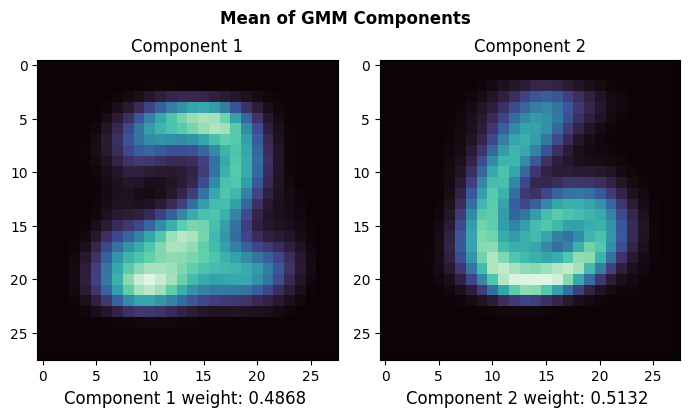

In [5]:
#|echo: false

# part 1.b
fig, axes = plt.subplots(1, 2, figsize = (7, 4))

for k, ax in enumerate(axes):
    mean_img = (np.dot(mean[k], V.T)).reshape((28, 28), order='F')
    ax.imshow(mean_img, cmap='mako')

    ax.set_xlabel(f"Component {k + 1} weight: {weights[k]:.4f} ", fontsize=12)
    plt.suptitle('Mean of GMM Components', fontweight = 'bold')
    ax.set_title(f'Component {k + 1}')

plt.tight_layout()
plt.show()

The means are displayed as images, corresponding to a kind of "average" of the images. Below each image, I have also provided the numerical weights of each component. Component 2 seems to have a slightly higher weight than component 1 which might indicate that it was a better fit with less errors. This can be verified in a moment with the misclassification results.

I have also plotted two 4-by-4 covariance matrices by visualizing their intensities using a heatmap. These are shown below for each component. 

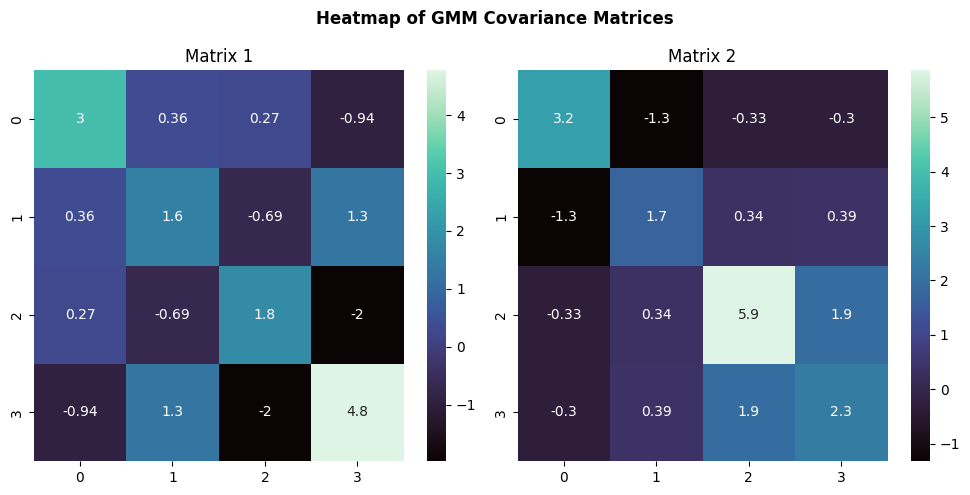

In [6]:
#|echo: false

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

for k, ax in enumerate(axes):
    sns.heatmap(sigma[k], cmap = 'mako', annot = True, ax = ax)
    ax.set_title(f'Matrix {k + 1}')
    plt.suptitle('Heatmap of GMM Covariance Matrices', fontweight = 'bold')
    plt.tight_layout()

## 1.3

By using the $\tau_{k}^i$ to infer the labels of the images and compare with the true labels, I can calculate the mis-classification rate (1 - Accuracy) for digits `2` and `6` respectively. I also performed $K$-means clustering with $K=2$ and found the  mis-classification rate for digits `2` and `6` respectively.

In [7]:
#|echo: false

# part 1.3
# Misclassification rates for GMM

def plot_cf(true_labels, pred_labels, title):

    pred_labels[pred_labels == 0] = 2
    pred_labels[pred_labels == 1] = 6

    cf_matrix = confusion_matrix(true_labels, pred_labels)

    overall_accuracy = np.trace(cf_matrix) / float(np.sum(cf_matrix))
    accuracy_2s = cf_matrix[0,0] / (cf_matrix[0,0] + cf_matrix[0,1])
    accuracy_6s = cf_matrix[1,1] / (cf_matrix[1,0] + cf_matrix[1,1])

    misclass_rate_2s = 1 - accuracy_2s
    misclass_rate_6s = 1 - accuracy_6s

    # From https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    plot_labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    plot_labels = np.asarray(plot_labels).reshape(2,2)

    plt.figure(figsize=(5, 4))
    
    sns.heatmap(cf_matrix, 
                annot = plot_labels, fmt = '', cmap = 'mako', 
                xticklabels = [2, 6], 
                yticklabels = [2, 6])

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {title}')
    
    metrics_text = (f'Overall Accuracy: {overall_accuracy:.2%}\n\n'
            f'Misclassification Rate for 2s: {misclass_rate_2s:.2%}\n'
            f'Misclassification Rate for 6s: {misclass_rate_6s:.2%}')
    plt.figtext(1, 0.5, metrics_text, fontsize=11, va='center')

    plt.tight_layout()
    plt.show()

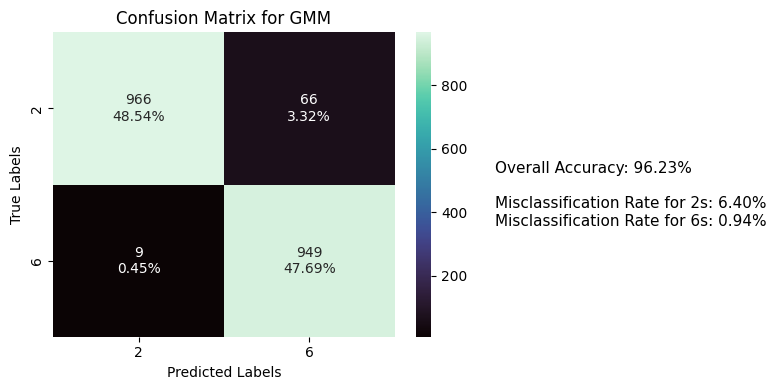

In [8]:
#|echo: false

pred_labels = np.argmax(tau, axis = 1)
plot_cf(true_labels, pred_labels, title = 'GMM')

The confusion matrix above shows that the GMM model had an overall accuracy of 96.23% with misclassification rates of 6.40% for images of the digit `2` and 0.94% for images of the digit `6`. The model was able to fit images of the digit `6` much better than images of the digit `2` and this was implied earlier when component 2 corresponding to the digit `6` had a slightly higher weight.

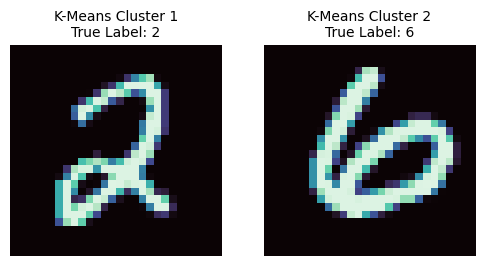

In [9]:
#|echo: false

# kmeans algorithm on pca_data (4 dimensions)
kmeans = KMeans(n_clusters = 2, random_state = 123456)

kmeans_fit = kmeans.fit(pca_data)
kmeans_labels = kmeans_fit.labels_
kmeans_centers = kmeans_fit.cluster_centers_

# find which kmeans cluster corresponds to 2 and 6 
#598 = 2, 1540 = 6 (found by randomly picking data points)
indices = [598, 1540]
fig, axes = plt.subplots(1, len(indices), figsize=(6, 4))

for i, idx in enumerate(indices):
    random_point = data[idx].reshape((28, 28), order='F')
    random_label = kmeans_labels[idx]
    true_label = true_labels[idx]

    axes[i].imshow(random_point, cmap='mako')
    axes[i].set_title(f"K-Means Cluster {random_label + 1}\nTrue Label: {true_label}", fontsize = 10)
    axes[i].axis(False)

plt.show()

## -- for visualizing kmeans on original data, not pca_data --
# fig, axes = plt.subplots(1, 2, figsize=(12, 12))
# for k, ax in enumerate(axes):
#     center = kmeans_centers[k].reshape((28, 28), order='F')
#     ax.imshow(center, cmap='mako')
#     ax.set_title(f"K-Means Cluster {k+1}")
# plt.tight_layout()
# plt.show()

I also performed K-means clustering on the the reduced image dataset with 4 dimensions using PCA and the plot of each cluster is shown above. This was important to plot since depending on the seed for randomization, cluster 1 could show images of `6` instead of `2` which would not match with the GMM model from before. I simply plotted the clusters to make sure that my function that calculates misclassification rates for the labels worked correctly by mapping predicated labels of `0` to `2` and `1` to `6`. 

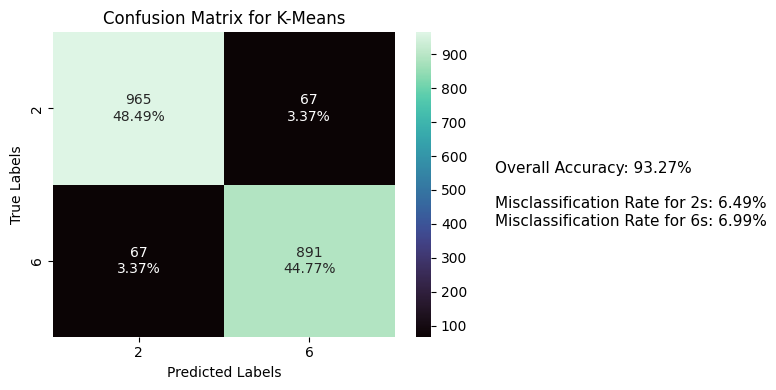

In [10]:
#|echo: false

plot_cf(true_labels, kmeans_labels, 'K-Means')

As seen from the confusion matrix for the K-Means algorithm output above, the K-Means algorithm performed slightly worse than the GMM model. The overall accuracy was lower (93.27% vs 96.23% of the GMM model) and the misclassification rates for both digits were higher than the GMM model. For the digit `2`, the misclassification rate was 6.49% which is slightly higher than the 6.40% rate from the GMM model, and for the digit `6`, the misclassification rate was 6.99% which is also much higher than the 0.94% rate from the GMM model.

Overall, the GMM model with the EM algorithm had better performance than the K-means algorithm in identifying the correct labels for the MNIST dataset. 

# 2 - Optimization

Consider a simplified logistic regression problem. 
Given $m$ training samples $(x^i, y^i)$, $i = 1, \ldots, m$, the data $x^i \in \mathbb R$, and $y^i \in \{0, 1\}$. In order to fit a logistic regression model for classification, we solve the following optimization problem, where $\theta \in \mathbb R$ is a parameter we aim to find:
$$ \max_\theta \ell (\theta), \tag{1} $$
where the log-likelhood function 

$$ \ell(\theta) = \sum_{i=1}^m \left\{-\log (1+\exp\{-\theta^T x^i\}) + (y^i-1) \theta^T x^i\right\}. $$

## 2.1 
>**Question:**  Show step-by-step mathematical derivation for the gradient of the cost function $\ell(\theta)$ in (1).

To get the gradient of the cost function $\ell(\theta)$, I can take the derivative of $\ell(\theta)$.
$$
\ell'(\theta) = \sum_{i=1}^m \frac{d}{d\theta} \left\{ -\log (1+\exp\{-\theta x^i\})\right\} + \frac{d}{d\theta} \left\{ (y^i-1) \theta x^i\right\}
$$

I can break the expression into two parts and find the derivatives separately.

Derivative of $(-\log (1+\exp\{-\theta x^i\})$:
$$
f(\theta) = -\log (1 + \exp\{-\theta x^i\})
$$

Using the chain rule:
$$
\frac{d f(\theta)}{d\theta} = -\frac{1}{1 + \exp\{-\theta x^i\}} \cdot \frac{d}{d\theta}(1 + \exp\{-\theta x^i\})
$$
$$
\frac{d f(\theta)}{d\theta} = -\frac{1}{1 + \exp\{-\theta x^i\}} \cdot (-x^i \exp\{-\theta x^i\}) = \frac{x^i \exp\{-\theta x^i\}}{1 + \exp\{-\theta x^i\}}
$$

Derivative of $(y^i - 1) \theta x^i$:
$$
g(\theta) = (y^i - 1) \theta x^i
$$
$$
\frac{d g(\theta)}{d\theta} = (y^i - 1) x^i
$$

Combining both parts:
$$
\boxed {\ell'(\theta) = \sum_{i=1}^m \left\{ \frac{x^i \exp\{-\theta x^i\}}{1 + \exp\{-\theta x^i\}} + (y^i - 1) x^i \right\}}
$$


## 2.2 
>**Question:**  Write a pseudo-code for performing **gradient descent** to find the optimizer $\theta^*$. This is essentially what the training procedure does.

Initialize parameters $\theta^0$, tolerance level $\epsilon$, max iterations $T$, and step size or learning rate $\gamma$ > 0.

Iteratively do:

- $\theta^{t+1} \leftarrow  \theta^t + \gamma \sum_{i=1}^m \left\{ \frac{x^i \exp\{-\theta^t x^i\}}{1 + \exp\{-\theta^t x^i\}} + (y^i - 1) x^i \right\}$

While $\|\theta^{t+1} - \theta^t\| > \epsilon$ and $t \le T$.


## 2.3  

>**Question:** Write the pseudo-code for performing the **stochastic gradient descent** algorithm to solve the training of logistic regression problem (1). Please explain the difference between gradient descent and stochastic gradient descent for training logistic regression.

The pseudo-code for performing the stochastic gradient descent is:

Initialize parameter $\theta^0$, tolerance level $\epsilon$, number of subsets $K$, max iterations $T$, and initial step size or learning rate $\gamma^t$ > 0.

Randomly split the dataset into subsets $S_k$, where $k = 1,2,..., K$.

For each subset $S_k$, do:

- $\theta^{t+1} \leftarrow  \theta^t + \gamma^t \sum_{i \in S_k} \left\{ \frac{x^i \exp\{-\theta^t x^i\}}{1 + \exp\{-\theta^t x^i\}} + (y^i - 1) x^i \right\}$
- $\gamma^{t+1} = \frac{\gamma^t}{(t+1)}$

While $\|\theta^{t+1} - \theta^t\| > \epsilon$ and $t \le T$.

The difference between gradient descent and stochastic gradient descent for training logistic regression is that stochastic gradient descent uses a randomly sampled small subset at each iteration whereas gradient descent uses the whole data set to compute the gradient. Due to this difference, gradient descent converges very slowly for large datasets while stochastic gradient decent can converge much faster since it uses a small subset of the data for each iteration. 



## 2.4
> **Question:** We will **show that the training problem in basic logistic regression problem is concave.** Derive the Hessian matrix of $\ell(\theta)$ and based on this, show the training problem (1) is concave. Explain why the problem can be solved efficiently and gradient descent will achieve a unique global optimizer, as we discussed in class. 


To show that the training problem in basic logistic regression is concave, the Hessian matrix of $\ell(\theta)$ must be negative semi-definite. To get the Hessian matrix, I can take the second derivative of the gradient of the cost function.

Given the first derivative of the log-likelihood function:
$$
\ell'(\theta) = \sum_{i=1}^m \left\{ \frac{x^i \exp\{-\theta x^i\}}{1 + \exp\{-\theta x^i\}} + (y^i - 1) x^i \right\}
$$

I can take the second derivative:

$$
\ell''(\theta) = \frac{d}{d\theta} \left( \sum_{i=1}^m \left\{ \frac{x^i \exp\{-\theta x^i\}}{1 + \exp\{-\theta x^i\}} + (y^i - 1) x^i \right\} \right)
$$

The second derivative of the term $(y^i - 1)x^i$ is zero because it does not depend on $\theta$.

Differentiating the term $\frac{x^i \exp\{-\theta x^i\}}{1 + \exp\{-\theta x^i\}}$ by using the quotient rule for differentiation:

$$
\frac{d}{d\theta} \left( \frac{x^i \exp\{-\theta x^i\}}{1 + \exp\{-\theta x^i\}} \right) = \frac{(- (x^i)^2 \exp\{-\theta x^i\}) (1 + \exp\{-\theta x^i\}) - (x^i \exp\{-\theta x^i\})(-x^i \exp\{-\theta x^i\})}{(1 + \exp\{-\theta x^i\})^2}
$$

$$
= \frac{-(x^i)^2 \exp\{-\theta x^i\}}{(1 + \exp\{-\theta x^i\})^2}
$$

Simplifying, we get the Hessian Matrix:

$$
\ell''(\theta) = \sum_{i=1}^m \left( \frac{-(x^i)^2 \exp\{-\theta x^i\}}{(1 + \exp\{-\theta x^i\})^2} \right)
$$

This Hessian Matrix is always negative, meaning that the log-likelihood function $\ell(\theta)$ is concave which ensures that there is a unique global maximum. This is an efficient solution because the gradient ascent will efficiently converge to the unique global optimizer, guaranteeing that logistic regression can be solved effectively with a unique global solution. 

# 3 - Bayes Classifier for spam filtering

In this problem, I will use the Bayes Classifier algorithm to fit a spam filter by hand. This will enhance my understanding of the Bayes classifier and build intuition. This question does not involve any programming but only derivation and hand calculation. Tools can be used (Python, Excel, Etc.) but all calculations and derivations will still be provided.

Spam filters are used in all email services to classify received emails as `Spam` or `Not Spam`. A simple approach involves maintaining a vocabulary of words that commonly occur in `Spam` emails and classifying an email as `Spam` if the number of words from the dictionary that are present in the email is over a certain threshold. We are given the vocabulary consists of 15 words $V=\{\textsf{secret, offer, low, price, valued, customer, today, dollar, million, sports, is, for, play, healthy, pizza}\}.$ 

We will use $V_i$ to represent the $i\text{th}$ word in $V$. As our training dataset, we are also given 3 example spam messages,

- million dollar offer for today
- secret offer today
- secret is secret

and 4 example non-spam messages

- low price for valued customer today
- play secret sports today
- sports is healthy
- low price pizza today

Recall that the Naive Bayes classifier assumes the probability of an input depends on its input feature. The feature for each sample is defined as
$x^{(i)} = [x_1^{(i)}, x_2^{(i)}, \ldots, x_d^{(i)}]^T$, $i = 1, \ldots, m$ and the class of the $i\text{th}$ sample is $y^{(i)}$. In our case the length of the input vector is $d = 15$, which is equal to the number of words in the vocabulary $V$. Each entry $x_j^{(i)}$ is equal to the number of times word $V_j$ occurs in the $i$-th message. 

## 3.1

I can calculate class prior $\mathbb P(y = 0)$ and $\mathbb P(y = 1)$ from the training data, where $y = 0$ corresponds to spam messages, and $y = 1$ corresponds to non-spam messages. Note that these class prior essentially corresponds to the frequency of each class in the training sample. I will also write down the feature vectors for each spam and non-spam messages.


To first calculate the class priors $\mathbb{P}(y = 0)$ and $\mathbb{P}(y = 1)$, I need to determine the frequency of each class in the training data. Here, $y = 0$ corresponds to spam messages, and $y = 1$ corresponds to non-spam messages.

$$
\mathbb{P}(y = 0) = \frac{\text{Number of spam messages}}{\text{Total number of messages}} = \frac{3}{7}
$$

$$
\mathbb{P}(y = 1) = \frac{\text{Number of non-spam messages}}{\text{Total number of messages}} = \frac{4}{7}
$$

Next, I can get the feature vectors for each spam and non-spam message using Python. I can represent each message as a vector $x^{(i)}$ where each entry $x_j^{(i)}$ is the number of times word $V_j$ occurs in the $i$-th message. The Python code can be found in the attached zip file.

In [11]:
#|echo: false

vocabulary = ["secret", "offer", "low", "price", "valued", "customer", "today", "dollar", "million", "sports", "is", "for", "play", "healthy", "pizza"]

spam_messages = [
    "million dollar offer for today",
    "secret offer today",
    "secret is secret"
]
non_spam_messages = [
    "low price for valued customer today",
    "play secret sports today",
    "sports is healthy",
    "low price pizza today"
]

def create_feature_vector(message, vocabulary):
    words = message.split()
    feature_vector = [words.count(word) for word in vocabulary]
    return feature_vector

spam_feat_vectors = [create_feature_vector(msg, vocabulary) for msg in spam_messages]

non_spam_feat_vectors = [create_feature_vector(msg, vocabulary) for msg in non_spam_messages]

df_spam_msgs = pd.DataFrame({'Spam Message': spam_messages, 'Feature Vector': spam_feat_vectors})
df_non_spam_msgs = pd.DataFrame({'Non-Spam Message': non_spam_messages, 'Feature Vector': non_spam_feat_vectors})

display(df_spam_msgs.style.hide(axis="index").set_caption("Feature Vectors of Spam Messages"))
display(df_non_spam_msgs.style.hide(axis="index").set_caption("Feature Vectors of Non-Spam Messages"))

Spam Message,Feature Vector
million dollar offer for today,"[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]"
secret offer today,"[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
secret is secret,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


Non-Spam Message,Feature Vector
low price for valued customer today,"[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]"
play secret sports today,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]"
sports is healthy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]"
low price pizza today,"[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]"


## 3.2

Assuming the keywords follow a multinomial distribution, the likelihood of a sentence with its feature vector $x$ given a class $c$ is given by 
$$
 \mathbb P (x|y = c) = \frac{n!}{x_1! \cdots x_d!}\prod_{k=1}^d \theta_{c, k}^{x_k}, \quad c = \{0, 1\}
$$

where $n = x_1 + \cdots x_d$, $0 \leq \theta_{c,k} \leq 1$ is the probability of word $k$ appearing in class $c$, which satisfies 

$$
\sum_{k=1}^d \theta_{c,k} = 1, \quad c = \{0, 1\}.
$$

Given this, the complete log-likelihood function for our training data is given by

$$
\ell(\theta_{0,1}, \ldots, \theta_{0, d}, \theta_{1,1}, \ldots, \theta_{1, d}) = 
\sum_{i=1}^m \sum_{k=1}^d x_k^{(i)} \log \theta_{y^{(i)}, k}
$$

(In this example, $m = 7$). I can calculate the maximum likelihood estimates of $\theta_{0,1}$, $\theta_{0,7}$, $\theta_{1,1}$, $\theta_{1,15}$ by maximizing the log-likelihood function above. 

(Note/Hint: We are solving a constrained maximization problem and will need to introduce Lagrangian multipliers and consider the Lagrangian function.)

**Steps to calculate the MLE estimates for $\theta_{c,k}$:**

To start, I can first get the joint probability of $y$ (class label) and $X$ (feature vector). 

Given the multinomial distribution assumption, the joint probability of $y$  and $X$ is:

$$ \mathbb{P}(y=c, X=x) = \mathbb{P}(y=c) \cdot \mathbb{P}(X=x \mid y=c) $$

where:

- $\mathbb{P}(y=c)$ is the prior probability of class $c$.
- $\mathbb{P}(X=x \mid y=c)$ is the likelihood of observing feature vector $x$ given class $c$.

The log-likelihood function $\ell(\theta_{0,1}, \ldots, \theta_{0,d}, \theta_{1,1}, \ldots, \theta_{1,d})$ for the entire dataset can be written as:

$$ \ell(\theta_{0,1}, \ldots, \theta_{0,d}, \theta_{1,1}, \ldots, \theta_{1,d}) = \sum_{i=1}^{m} \log \left( \mathbb{P}(X^{(i)} = x^{(i)}, y^{(i)} = c) \right) $$

where $m$ is the number of training examples, $X^{(i)}$ is the feature vector of the $i$-th example, and $y^{(i)}$ is its class label.

To handle the constraint $\sum_{k=1}^{d} \theta_{c,k} = 1$, I can use Lagrange multipliers $\lambda_c$ for each class $c$.

The Lagrangian function is:

$$ \mathcal{L}(\theta_{0,1}, \ldots, \theta_{0,d}, \theta_{1,1}, \ldots, \theta_{1,d}, \lambda_0, \lambda_1) = \sum_{i=1}^{m} \sum_{k=1}^{d} x_k^{(i)} \log \theta_{y^{(i)}, k} + \lambda_0 \left( 1 - \sum_{k=1}^{d} \theta_{0,k} \right) + \lambda_1 \left( 1 - \sum_{k=1}^{d} \theta_{1,k} \right) $$

The objective function to maximize can be obtained by setting the derivative of $\mathcal{L}$ with respect to each $\theta_{c,k}$ to $0$:

$$ \frac{\partial \mathcal{L}}{\partial \theta_{c,k}} = \sum_{i=1}^{m} \frac{x_k^{(i)}}{\theta_{c,k}} - \lambda_c = 0 $$

From the above derivative, I can solve for $\theta_{c,k}$:

$$ \theta_{c,k} = \frac{\sum_{i=1}^{m} x_k^{(i)}}{\lambda_c} $$

Using the constraint $\sum_{k=1}^{d} \theta_{c,k} = 1$:

$$ \lambda_c = \sum_{k=1}^{d} \sum_{i=1}^{m} x_k^{(i)} $$

Therefore,

$$ \boxed {\theta_{c,k} = \frac{\sum_{i=1}^{m} x_k^{(i)}}{\sum_{k=1}^{d} \sum_{i=1}^{m} x_{k}^{(i)}}}$$

This gives us the maximum likelihood estimate $\theta_{c,k}$ for each class $c$ and each word $k$ in the vocabulary.

This expression makes sense and represents the maximum likelihood estimate of the probability that word $V_k$ appears in messages of class $c$, where $c$ could be spam (c=0) or non-spam (c=1). It measures how frequently each word occurs relative to all words observed in the training data for that class. This estimate also ensures that probabilities are normalized across all words in the vocabulary for each class.

I wrote some code in Python that calculates the estimates using the boxed expression above and the output tables are shown below. The code can be found in the zip file attached to this report.

In [12]:
#|echo: false

spam_feat_vectors = df_spam_msgs['Feature Vector'].values.tolist()
non_spam_feat_vectors = df_non_spam_msgs['Feature Vector'].values.tolist()

sum_spam_vectors = np.sum(spam_feat_vectors, axis = 0)
sum_non_spam_vectors = np.sum(non_spam_feat_vectors, axis = 0)

total_spam_words = np.sum(sum_spam_vectors)
total_non_spam_words = np.sum(sum_non_spam_vectors)

# likelihood estimates theta_{c,k}
theta_spam = np.round(sum_spam_vectors / total_spam_words, 4)
theta_non_spam = np.round(sum_non_spam_vectors / total_non_spam_words, 4)

results = pd.DataFrame({
    'Word': vocabulary,
    'Sum of Spam Vectors': sum_spam_vectors,
    'Total Num of Spam Words': total_spam_words,
    'Theta (spam)': theta_spam,
    'Sum of Non-Spam Vectors': sum_non_spam_vectors,
    'Total Num of Non-Spam Words': total_non_spam_words,
    'Theta (non-spam)': theta_non_spam
})
results.index += 1

# results['Theta_Spam_Ratio'] = results.apply(lambda row: "{}/{}".format(row['sum_spam_vectors'], row['total_spam_words']), axis=1)
df_spam = results[['Word', 'Sum of Spam Vectors', 'Total Num of Spam Words', 'Theta (spam)']]
df_non_spam = results[['Word', 'Sum of Non-Spam Vectors', 'Total Num of Non-Spam Words', 'Theta (non-spam)']]

display(df_spam.style.set_caption("Spam Word Frequencies").format(precision=3))
display(df_non_spam.style.set_caption("Non-spam Word Frequencies").format(precision=3))

# print("Theta_0,1 = {}/{}".format(df_spam.at[1, 'Sum of Spam Vectors'], df_spam.at[1, 'Total Num of Spam Words']))
# print("Theta_0,7 = {}/{}".format(df_spam.at[7, 'Sum of Spam Vectors'], df_spam.at[7, 'Total Num of Spam Words']))
# print("Theta_1,1 = {}/{}".format(df_non_spam.at[1, 'Sum of Non-Spam Vectors'], df_non_spam.at[1, 'Total Num of Non-Spam Words']))
# print("Theta_1,15 = {}/{}".format(df_non_spam.at[15, 'Sum of Non-Spam Vectors'], df_non_spam.at[15, 'Total Num of Non-Spam Words']))

,Word,Sum of Spam Vectors,Total Num of Spam Words,Theta (spam)
1,secret,3,11,0.273
2,offer,2,11,0.182
3,low,0,11,0.000
4,price,0,11,0.000
5,valued,0,11,0.000
6,customer,0,11,0.000
7,today,2,11,0.182
8,dollar,1,11,0.091
9,million,1,11,0.091
10,sports,0,11,0.000


,Word,Sum of Non-Spam Vectors,Total Num of Non-Spam Words,Theta (non-spam)
1,secret,1,17,0.059
2,offer,0,17,0.000
3,low,2,17,0.118
4,price,2,17,0.118
5,valued,1,17,0.059
6,customer,1,17,0.059
7,today,3,17,0.176
8,dollar,0,17,0.000
9,million,0,17,0.000
10,sports,2,17,0.118


Using the tables above, the maximum likelihood estimates are:

$$
\theta_{0,1} = \frac{3}{11}, \quad \theta_{0,7} = \frac{2}{11}
$$
$$
\theta_{1,1} = \frac{1}{17}, \quad \theta_{1,15} = \frac{1}{17}
$$

where in $\theta_{c,k}$, $c$ = 0 is spam and $c$ = 1 is non-spam, and $k$ = 1 is the word "secret", $k$ = 7 is the word "today" and $k$ = 15 is the word "pizza".

## 3.3 

Given a test message **today is secret** and by using the Naive Bayes classier that I trained in Part (1)-(2), I can calculate the posterior and decide whether it is spam or not spam. All derivations are shown below.

To classify the test message using the Naive Bayes classifier trained previously, I first need to convert the message into a feature vector based on the vocabulary. I used my Python code from before to get the following feature vector and $\theta$ values.

In [13]:
#|echo: false

test_message = 'today is secret'

test_message_feat_vector = create_feature_vector(test_message, vocabulary)
print(f"Test message: {test_message}\nFeature vector: {test_message_feat_vector}")

Test message: today is secret
Feature vector: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]


In [14]:
#|echo: false

# display(results)

print("'today':")
print("Theta_0,7 = {}/{}".format(df_spam.at[7, 'Sum of Spam Vectors'], df_spam.at[7, 'Total Num of Spam Words']))
print("Theta_1,7 = {}/{}".format(df_non_spam.at[7, 'Sum of Non-Spam Vectors'], df_non_spam.at[7, 'Total Num of Non-Spam Words']))
theta_0_7 = df_spam.at[7, 'Theta (spam)']
theta_1_7 = df_non_spam.at[7, 'Theta (non-spam)']

print("\n'is':")
print("Theta_0,11 = {}/{}".format(df_spam.at[11, 'Sum of Spam Vectors'], df_spam.at[11, 'Total Num of Spam Words']))
print("Theta_1,11 = {}/{}".format(df_non_spam.at[11, 'Sum of Non-Spam Vectors'], df_non_spam.at[11, 'Total Num of Non-Spam Words']))
theta_0_11 = df_spam.at[11, 'Theta (spam)']
theta_1_11 = df_non_spam.at[11, 'Theta (non-spam)']

print("\n'secret':")
print("Theta_0,1 = {}/{}".format(df_spam.at[1, 'Sum of Spam Vectors'], df_spam.at[1, 'Total Num of Spam Words']))
print("Theta_1,1 = {}/{}".format(df_non_spam.at[1, 'Sum of Non-Spam Vectors'], df_non_spam.at[1, 'Total Num of Non-Spam Words']))
theta_0_1 = df_spam.at[1, 'Theta (spam)']
theta_1_1 = df_non_spam.at[1, 'Theta (non-spam)']

'today':
Theta_0,7 = 2/11
Theta_1,7 = 3/17

'is':
Theta_0,11 = 1/11
Theta_1,11 = 1/17

'secret':
Theta_0,1 = 3/11
Theta_1,1 = 1/17


From the previous calculations, we know the class priors:

$$
\mathbb{P}(y=0) = \frac{3}{7}, \quad \mathbb{P}(y=1) = \frac{4}{7}
$$

Using the estimated $\theta_{c,k}$ values from the previous calculations and my python code from before, I can calculate the likelihood of the feature vector given each class.

For Spam ($y=0$):
$$
\theta_{0,7} = \frac{2}{11}, \quad \theta_{0,11} = \frac{1}{11}, \quad \theta_{0,1} = \frac{3}{11}
$$

For Non-Spam ($y=1$):
$$
\theta_{1,7} = \frac{3}{17}, \quad \theta_{1,11} = \frac{1}{17}, \quad \theta_{1,1} = \frac{1}{17}
$$

Using the multinomial distribution for the likelihood from before, I can simply take the product of the likelihoods for each class:

$$
\mathbb{P}(x|y=0) = \frac{2}{11} \cdot \frac{1}{11} \cdot \frac{3}{11} = \frac{6}{1331}
$$

$$
\mathbb{P}(x|y=1) = \frac{3}{17} \cdot \frac{1}{17} \cdot \frac{1}{17} = \frac{3}{4913}
$$

Using Bayes' theorem, the posterior probability is:

$$
\mathbb{P}(y=c|x) = \frac{\mathbb{P}(x|y=c) \cdot \mathbb{P}(y=c)}{\mathbb{P}(x|y=0) \cdot \mathbb{P}(y=0) + \mathbb{P}(x|y=1) \cdot \mathbb{P}(y=1)}
$$

To calculate the posterior probability of the message being spam, I can evaluate the expression below where $x$ is the test message and $c$ = 0:

$$
\mathbb{P}(y=0|x) = \frac{\mathbb{P}(x|y=0) \cdot \mathbb{P}(y=0)}{\mathbb{P}(x|y=0) \cdot \mathbb{P}(y=0) + \mathbb{P}(x|y=1) \cdot \mathbb{P}(y=1)}
$$

$$
\mathbb{P}(y=0|x) = \frac{\frac{6}{1331} \cdot \frac{3}{7}}{\frac{6}{1331} \cdot \frac{3}{7} + \frac{3}{4913} \cdot \frac{4}{7}}
$$

$$
\mathbb{P}(y=0|x) = {\frac{14739}{17401}} \approx 0.8470
$$

$$
\mathbb{P}(y=0|x) \approx 0.8470 > 0.5
$$

Given the posterior probabilities, the Naive Bayes classifier classifies the message "today is secret" as `spam` since it is above a chosen 0.5 threshold. The spam and non-spam probabilities sum up to 1 and so, we know that the probability of the test message being non-spam is about 0.153, or 15% which is very low compared to the 84.7% probability of the test message being spam. 

In [15]:
#|echo: false

# double check calculations

P_x_y0 = theta_0_7 * theta_0_11 * theta_0_1
P_x_y1 = theta_1_7 * theta_1_11 * theta_1_1
Py0 = 3/7
Py1 = 4/7

P_y0_x = P_x_y0 * Py0 / (P_x_y0 * Py0 + P_x_y1 * Py1)
# print(P_y0_x)
P_y1_x = P_x_y1 * Py1 / (P_x_y0 * Py0 + P_x_y1 * Py1)
# print(P_y1_x)

# 4 - Comparing classifiers: Divorce classification/prediction

In lectures, we learned different classifiers; this question compares them on two datasets.

This dataset is about participants who completed the personal information form and a divorce predictors scale. The data is a modified version of the publicly available at https://archive.ics.uci.edu/dataset/539/divorce+predictors+data+set (by injecting noise so we will not get the exactly same results as on UCI website). The dataset `marriage.csv` is contained in the data folder. There are 170 participants and 54 attributes (or predictor variables) that are all real-valued. The last column of the CSV file is label $y$ (1 means `divorce`, 0 means `no divorce`). Each column is for one feature (predictor variable), and each row is a sample (participant). A detailed explanation for each feature (predictor variable) can be found at the website link above. Our goal is to build a classifier using training data, such that given a test sample, we can classify (or essentially predict) whether its label is 0 (`no divorce`) or 1 (`divorce`). 

We are going to compare the following classifiers: **Naive Bayes, Logistic Regression, and KNN** using the first $80\%$ data for training and the remaining $20\%$ for testing. I will import **scikit-learn** and use **train\_test\_split** to split the dataset. 

*Remark: Please note that, here, for Naive Bayes, this means that we have to estimate the variance for each individual feature from training data. When estimating the variance, if the variance is zero to close to zero (meaning that there is very little variability in the feature), we can set the variance to be a small number, e.g., $\epsilon = 10^{-3}$. We do not want to have include zero or nearly variance in Naive Bayes. This tip holds for both Part One and Part Two of this question.*

## 4.1 

I can fit the models and report the testing accuracy for each of the three classifiers. 

In [16]:
#|echo: false

# load in data
marriage_data = read_csv('data/marriage.csv', header = None)

X = marriage_data.iloc[:, 0:54]
y = marriage_data.iloc[:, 54:]

# scales the data
X = StandardScaler().fit_transform(X)

# split into train/test splits (80/20) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2121)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))

In [17]:
#|echo: false

classification_models = {'Naive Bayes': GaussianNB(var_smoothing = 1e-3), 
                         'Logistic Regression': LogisticRegression(max_iter=200, solver='liblinear'),
                         'KNN': KNeighborsClassifier()
                         }

def fit_model(class_model):
    model = classification_models[class_model]
    model.fit(X_train, y_train)
    training_acc = model.score(X_train, y_train)
    testing_acc = model.score(X_test, y_test)

    outputs = pd.DataFrame({'Model': [class_model], 
                           'Training Accuracy': [training_acc], 
                           'Testing Accuracy': [testing_acc]})
    
    return outputs

In [18]:
#|echo: false

# part 4.a

classifier_results = pd.DataFrame()

for model in classification_models:
    result = fit_model(model)
    classifier_results = pd.concat([classifier_results, result], ignore_index = True)

display(classifier_results.style.hide(axis="index").set_caption("Evaluation Results of Classifier Models"))

Model,Training Accuracy,Testing Accuracy
Naive Bayes,0.977941,0.970588
Logistic Regression,1.000000,0.941176
KNN,0.977941,0.970588


As seen from the table above, all three classification models perform very well on the test dataset. Naive Bayes and KNN both had a testing accuracy of 97.1% while logistic regression had a slightly lower testing accuracy of 94.12%. This would make sense since logistic regression has a linear decision boundary whereas Naive Bayes and KNN have non-linear decision boundaries that are more flexible for classifying points in the dataset. The data is also easily separable and so all models in this case perform very well as expected. 

It should be noted that by changing the seed for the split function responsible for splitting the dataset into training and testing subsets, it changes the testing accuracies to times where all models have perfect accuracy or the ranking changes among them. I believe this is due to the lack of a large number of data points and the dataset being too generic that the models are able to overfit to the underlying patterns fairly easily.   

## 4.2

I will now perform PCA to project the data into two-dimensional space. As before, I will build the classifiers **(Naive Bayes, Logistic Regression, and KNN)** using the two-dimensional PCA results. Below, I have plotted the data points and decision boundary of each classifier in the two-dimensional space. 

In [19]:
#|echo: false

# part 4.b

pca = PCA(n_components = 2)
# pca_data = pca.fit_transform(X)
pca.fit(X)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

pca_classifier_results = pd.DataFrame()

for model in classification_models:
    result = fit_model(model)
    pca_classifier_results = pd.concat([pca_classifier_results, result], ignore_index = True)

display(pca_classifier_results.style.hide(axis="index").set_caption("Evaluation Results of Classifier Models on 2D Data with PCA"))

Model,Training Accuracy,Testing Accuracy
Naive Bayes,0.977941,0.970588
Logistic Regression,0.977941,0.970588
KNN,0.985294,0.970588


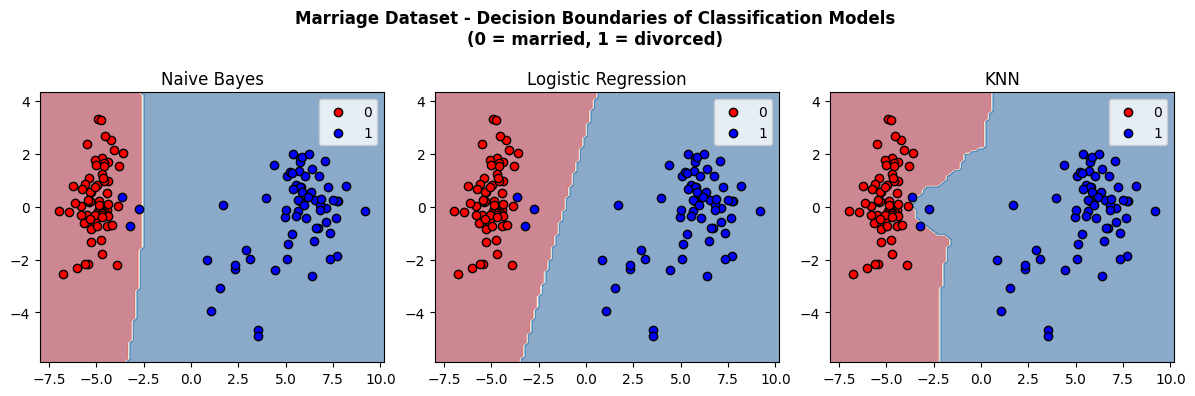

In [20]:
#|echo: false

# https://hackernoon.com/how-to-plot-a-decision-boundary-for-machine-learning-algorithms-in-python-3o1n3w07

def plot_decision_boundaries(classification_models):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for i, (model_name, model) in enumerate(classification_models.items()):
        model.fit(X_train, y_train)
        
        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                              np.linspace(y_min, y_max, 100))

        Z = model.predict(np.column_stack((xx.ravel(), yy.ravel())))
        Z = Z.reshape(xx.shape)

        # decision boundary and the data points
        ax = axes[i]
        ax.contourf(xx, yy, Z, alpha = 0.5, cmap = 'RdBu')
        
        unique_labels = np.unique(y_train)
        cm_bright = ['#FF0000', '#0000FF']

        for i in range(len(unique_labels)):
            label_indices = np.where(y_train == i)[0]
            ax.scatter(X_train[label_indices, 0], X_train[label_indices, 1], 
                       label = int(i), color = cm_bright[i], edgecolors='k')
        
        ax.legend()
        ax.set_title(f"{model_name}")

    plt.suptitle("Marriage Dataset - Decision Boundaries of Classification Models\n(0 = married, 1 = divorced)", fontweight = 'bold')
    plt.tight_layout()
    plt.show()
    

plot_decision_boundaries(classification_models)

Evident from the plots above, Naive Bayes and KNN both have non-linear decision boundaries whereas logistic regression has a linear decision boundary. The KNN decision boundary is very noisy and this may be due to the small default $k$ value of 5 in the algorithm that decides how many neighbors a point should have to classify a label. 
Compared to the testing accuracies from before, logistic regression on the 2-dimensional data had an improvement in the testing accuracy to where all three classification models now performed equally with an accuracy of 97.1%.
